# Homework: Not So Basic Artificial Neural Networks

Your task is to implement a simple framework for convolutional neural networks training. While convolutional neural networks is a subject of lecture 3, we expect that there are a lot of students who are familiar with the topic.

In order to successfully pass this homework, you will have to:

- Implement all the blocks in `homework_modules.ipynb` (esp `Conv2d` and `MaxPool2d` layers). Good implementation should pass all the tests in `homework_test_modules.ipynb`.
- Settle with a bit of math in `homework_differentiation.ipynb`
- Train a CNN that has at least one `Conv2d` layer, `MaxPool2d` layer and `BatchNormalization` layer and achieves at least 97% accuracy on MNIST test set.

Feel free to use `homework_main-basic.ipynb` for debugging or as source of code snippets. 

Note, that this homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook with cnn trained
- `homework_modules.ipynb`
- `homework_differentiation.ipynb`

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# (re-)load layers
%run homework_modules.ipynb

In [3]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
        x_batch = X[batch_idx]
        y_batch = np.eye(10)[Y[batch_idx]]
        yield x_batch, y_batch

In [4]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()  # your dataset

In [5]:
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)
X_test = np.expand_dims(X_test, axis=1)

In [6]:
model = Sequential()

model.add(Conv2d(in_channels=1, out_channels=4, kernel_size=3))
model.add(ReLU())
model.add(MaxPool2d(kernel_size=2))
model.add(Conv2d(in_channels=4, out_channels=8, kernel_size=3))
model.add(ReLU())
model.add(MaxPool2d(kernel_size=2))
model.add(Flatten())
model.add(Linear(n_in = 8 * 7 * 7, n_out = 64))
model.add(BatchNormalization(alpha=.9))
model.add(ReLU())
model.add(Linear(n_in = 64, n_out = 10))
model.add(LogSoftMax())

criterion = ClassNLLCriterion()

In [7]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, dataset):
    X, y = dataset
    preds = model.forward(X)
    preds = preds.argmax(axis=1)
    return accuracy_score(preds, y)

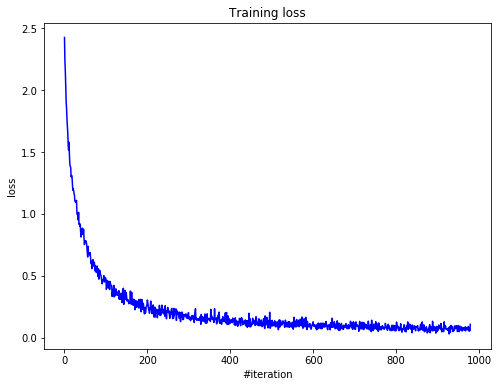

Current loss: 0.107123
Val accuracy: 0.976700


In [8]:
from tqdm import tqdm

n_epoch = 5
batch_size = 256

optimizer_config = {'learning_rate' : 1e-3, 'beta1' : 0.9, 'beta2' : 0.999, 'epsilon' : 1e-4}
optimizer_state = {}

loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size), position=0):
        model.zeroGradParameters()

        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        dp = criterion.backward(predictions, y_batch)
        model.backward(x_batch, dp)

        adam_optimizer(model.getParameters(), 
                       model.getGradParameters(), 
                       optimizer_config,
                       optimizer_state)      

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)
    model.evaluate()
    print('Val accuracy: %f' % evaluate_model(model, (X_val, y_val)))
    model.train()

Print here your accuracy on test set. It should be >97%. Don't forget to switch the network in 'evaluate' mode

In [9]:
model.evaluate()
print('Test accuracy: %f' % evaluate_model(model, (X_test, y_test)))

Test accuracy: 0.975900
